# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values.

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [ ]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.**

For a detailed description of the dataset features, please refer to  **Appendix 1** below.

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split.

In [ ]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df_zillow = pd.read_csv(filename)

File downloaded successfully.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data;
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:**

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**1.1 Answer:** The objective of this project is to develop a predictive model that estimates the assessed tax value of residential properties based on their various property features. This model offers a data-driven approach to enhance the accuracy and efficiency of property tax assessments, thereby aiding in pricing decisions, negotiations, and market analysis. In addition, it identifies the features that hold the greatest significance in property valuation.

**1.2:**  How will your solution be used?


**1.2 Answer:** The model will be used to automate and enhance property assessments by delivering consistent and scalable estimates of assessed tax values based on various property features. It will identify which factors contribute to higher property values; for example, if the neighborhood is a significant determinant, we can pinpoint which neighborhoods tend to have higher property values. This information could influence construction decisions across different areas of the neighborhood, city, or county.

**1.3:**  How should success (or failure) be measured?


**1.3 Answer:**
*   Technical Success Measures: Success
will be assessed by achieving a low Root Mean Square Error (RMSE), a high R-squared value (preferably exceeding 0.8), and consistent predictive performance, indicated by a low standard deviation of RMSE.
*   Business Success Measures: The model should accurately and consistently predict property values while being efficient in terms of hardware usage and time. It should also be modular and adaptable to accommodate new data.


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process.
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [ ]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.8 MB/s eta 0:00:00


In [ ]:
# Drop duplicated rows
num_duplicates = df_zillow.duplicated().sum()
df = df_zillow.drop_duplicates()
print(f'{num_duplicates} rows were dropped due to duplication')

199 rows were dropped due to duplication


In [ ]:
from itables import show
show(df.head())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77414 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77414 non-null  int64  
 1   airconditioningtypeid         24953 non-null  float64
 2   architecturalstyletypeid      206 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77381 non-null  float64
 5   bedroomcnt                    77381 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49672 non-null  float64
 8   calculatedbathnbr             76772 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6023 non-null   float64
 11  calculatedfinishedsquarefeet  77185 non-null  float64
 12  finishedsquarefeet12          73749 non-null  float64
 13  finish

In [ ]:
df.nunique().sort_values(ascending = True)

decktypeid                          1
pooltypeid7                         1
pooltypeid2                         1
pooltypeid10                        1
poolcnt                             1
hashottuborspa                      1
taxdelinquencyflag                  1
storytypeid                         1
fireplaceflag                       1
assessmentyear                      1
buildingclasstypeid                 2
regionidcounty                      3
fips                                3
typeconstructiontypeid              4
numberofstories                     4
threequarterbathnbr                 4
architecturalstyletypeid            5
fireplacecnt                        5
airconditioningtypeid               5
unitcnt                             8
heatingorsystemtypeid              10
buildingqualitytypeid              12
propertylandusetypeid              13
taxdelinquencyyear                 13
fullbathcnt                        13
finishedsquarefeet13               13
garagecarcnt                       14
bedroomcnt                         16
roomcnt                            16
calculatedbathnbr                  21
bathroomcnt                        22
basementsqft                       43
yardbuildingsqft26                 59
propertycountylandusecode          75
yearbuilt                         136
regionidcity                      175
poolsizesum                       262
finishedsquarefeet6               350
regionidzip                       389
regionidneighborhood              480
yardbuildingsqft17                540
garagetotalsqft                   839
finishedsquarefeet15             1724
finishedfloor1squarefeet         1787
finishedsquarefeet50             1807
propertyzoningdesc               1907
finishedsquarefeet12             4868
calculatedfinishedsquarefeet     4972
lotsizesquarefeet               18848
censustractandblock             39006
rawcensustractandblock          39188
taxvaluedollarcnt               50949
longitude                       62461
latitude                        64038
parcelid                        77414
dtype: int64

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

**2.A.1 Answer:**
*   Based on the data types identified in the DataFrame summary (df.info()), the following features are currently set as object or categorical types: hashottuborspa, propertycountylandusecode, propertyzoningdesc, fireplaceflag, taxdelinquencyflag.

*   Several variables in the dataset are stored as numeric but do not carry true numerical meaning. Instead, they represent types, regions, or classifications, and are better treated as categorical features. These include ID-like or coded variables (i.e., nominal), such as: parcelid, airconditioningtypeid, architecturalstyletypeid, buildingclasstypeid, decktypeid, fips, hashottubeorspa, heatingorsystemtypeid, pooltypeid10, pooltypeid2, pooltypeid7, propertylandusetypeid, rawcensustractandblock, regionidcity, regionidcounty, regionidneighborhood, regionidzip, storytypeid, typeconstructiontypeid, censustractandblock. In addition, buildingqualitytypeid is an ordinal variable, as it represents a ranked scale of building quality, where higher values indicate better quality.

*   While some variables are numeric in format, they represent discrete counts (i.e., interval) rather than continuous measurements. These can potentially be treated as categorical features: bathroomcnt, bedroomcnt, calculatedbathnbr, fireplacecnt, fullbathcnt, garagecarcnt, roomcnt, threequarterbathnbr, unitcnt, and numberofstories.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.

**2.A.2 Answer:** Based on the feature descriptions provided in Appendix 1, we identified the following features as unlikely to be useful for business purposes: fips, censustractandblock, rawcensustractandblock, latitude, and longitude. These are primarily unique identifiers, often created for census or administrative use, and **are not expected to have a direct impact on property pricing.** **They function more as locational references than as predictive business features.** While we could consider keeping latitude and longitude for potential geo-based clustering or mapping, we already have neighborhood, city, and county identifiers, which may provide sufficient location granularity for our analysis.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example.

**2.A.3 Answer:** We reviewed the missing value count for each column (See results below) and decided to exclude any **features with more than 50,000 missing values**, which corresponds to roughly two-thirds **(66%)** of the values within a feature. When a feature is missing this much data, it becomes difficult to impute accurately and may introduce bias into the analysis. While 66% is still a significant amount of missing data, we chose to retain as many features as possible at this stage. We will proceed with caution when handling these features in later steps.
**For example,** variables like buildingclasstypeid, finishedsquarefeet13, basementsqft, storytypeid, and yardbuildingsqft26 each have fewer than 100 non-null entries out of 77,613 total samples, meaning they are over 99.9% missing. With so little available data, these features are unlikely to add value and are therefore excluded from further analysis. **One exception** is the **taxdelinquencyflag** feature, which has 96.26% missing values. However, based on the feature description, **missing values can reasonably be interpreted as “No”**, indicating the property is not tax delinquent. Therefore, we can impute the missing values with “No” rather than excluding the feature.

In [ ]:
# Check count and percentage of missing data for each columns
def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)

    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values,
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)

    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name                  # Nulls      Null %     Type')
        print('------------                  -------      ------     ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<30} {row['# Null Values']:<11} {row['Null %']:.2f}%   {row['Type']}")

show_null_counts_features(df)

The dataset contains 77414 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
buildingclasstypeid            77399       99.98%   Numeric
finishedsquarefeet13           77373       99.95%   Numeric
basementsqft                   77364       99.94%   Numeric
storytypeid                    77364       99.94%   Numeric
yardbuildingsqft26             77344       99.91%   Numeric
fireplaceflag                  77242       99.78%   Categorical
architecturalstyletypeid       77208       99.73%   Numeric
typeconstructiontypeid         77192       99.71%   Numeric
finishedsquarefeet6            77028       99.50%   Numeric
pooltypeid10                   76950       99.40%   Numeric
decktypeid                     76800       99.21%   Numeric
poolsizesum                    76547       98.88%   Numeric
pooltypeid2                    76340       98.61%   Numeric
hashottuborspa                 75876       98.01%   Categoric

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example.

**2.A.4 Answer:** Based on the unique value counts (See results above), our main concern is with features that have nearly unique values per property or only one unique value, as they offer little to no predictive value.
*   **Nearly unique per property:** Features such as parcelid, latitude, and longitude have a high number of unique values, with nearly one unique value per property. Therefore, they provide little to no generalizable predictive value and are better suited as identifiers or spatial references rather than features for modeling.
*   **No variance (only one unique value)**: The following features have only one unique value across the dataset, offering no variance and therefore no value for prediction or analysis: poolcnt, storytypeid, pooltypeid7, pooltypeid2, pooltypeid10, fireplaceflag, hashottuborspa, decktypeid, taxdelinquencyflag, and assessmentyear (2016). However, some of these appear to be binary variables that currently contain only one observed value. We plan to explore these further to determine whether their lack of variance is due to data limitations or if they can be safely removed.



### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

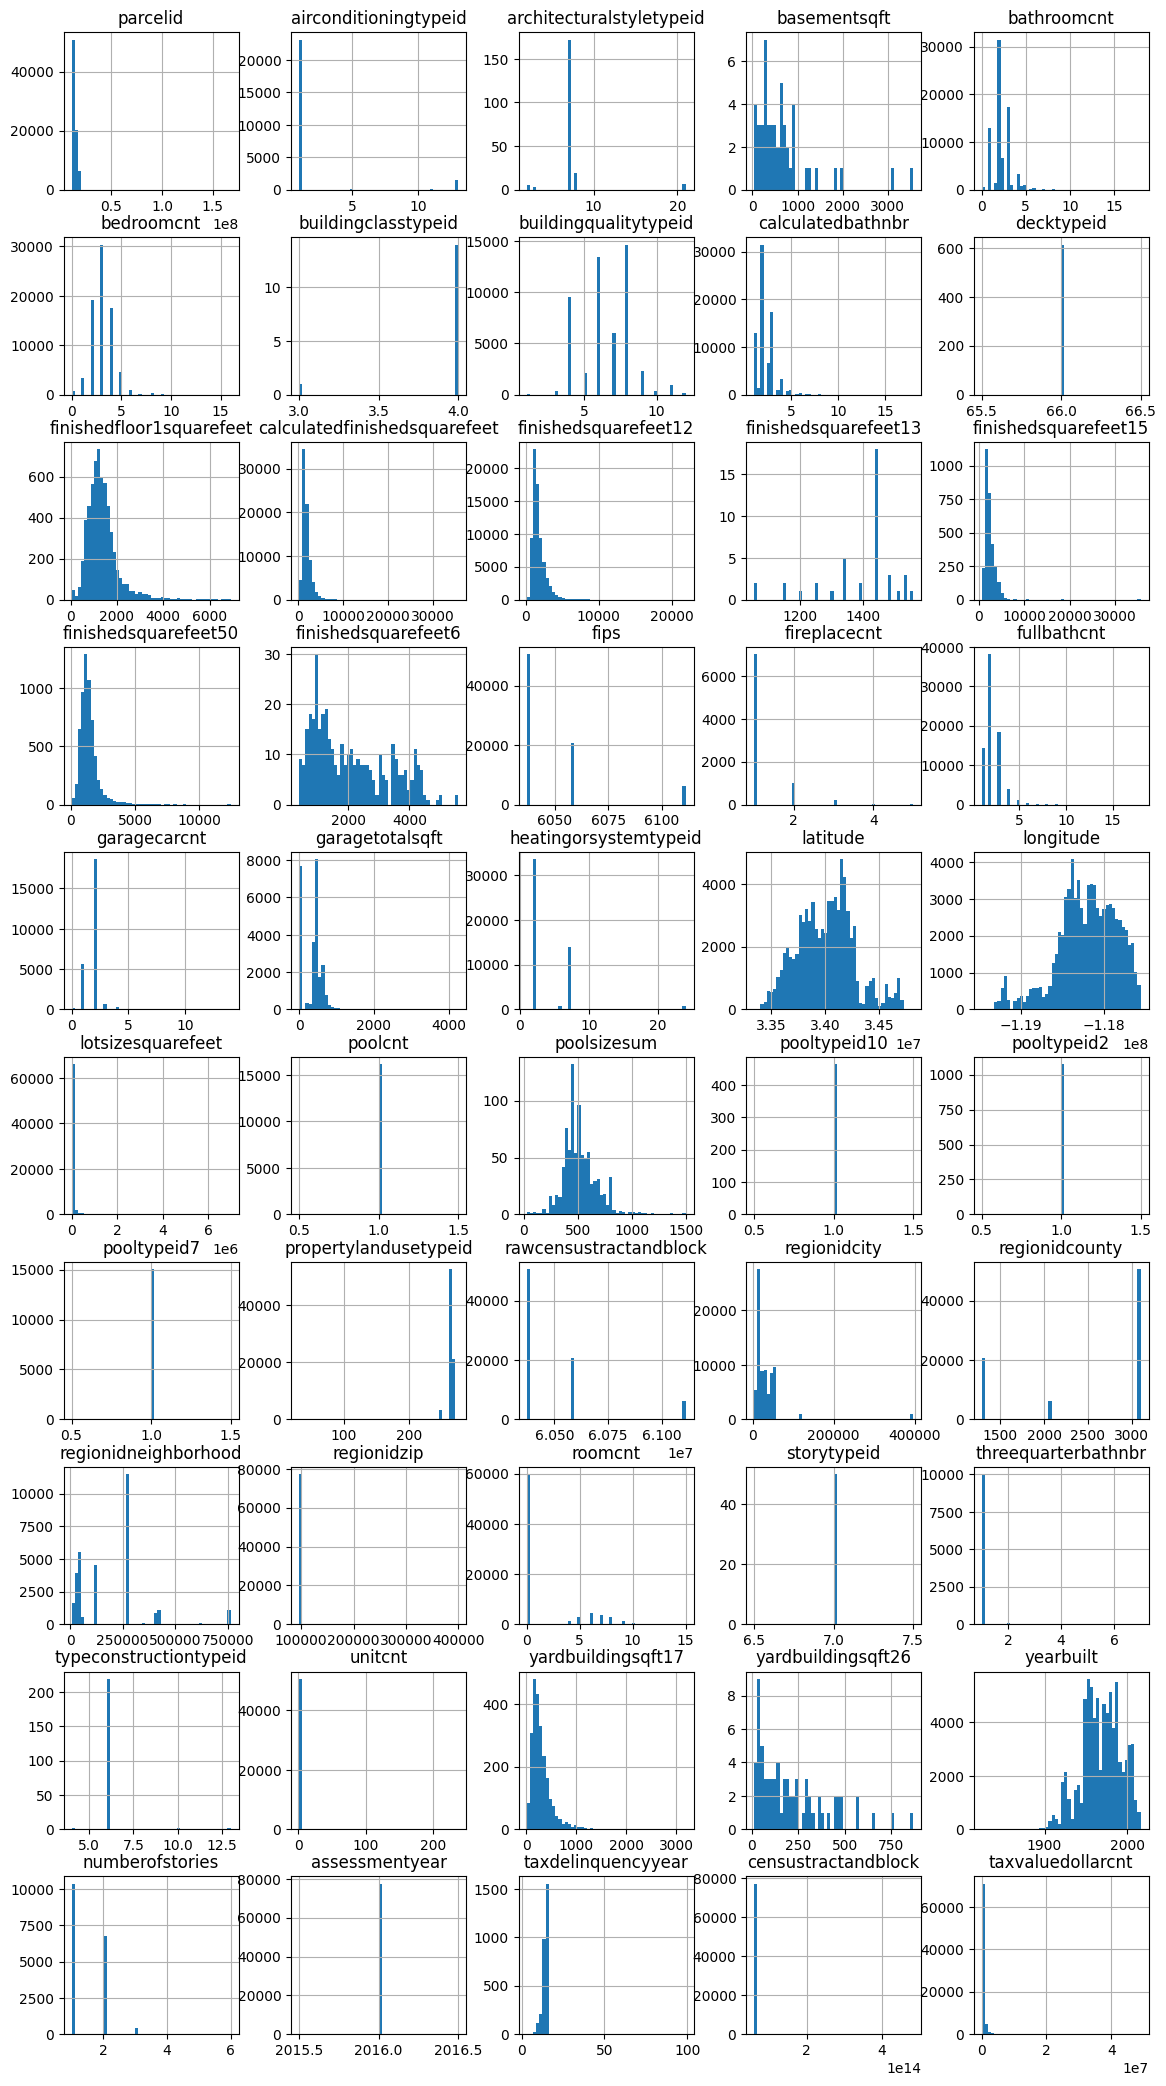

In [ ]:
# Histogram for all variables
df.hist(figsize = (14,26), bins = 50, layout = (-1, 5));

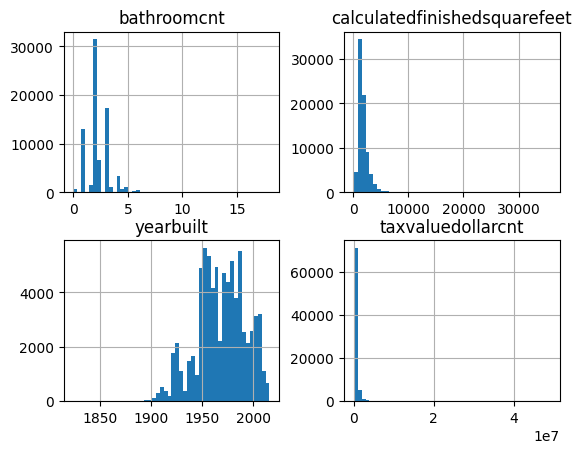

In [ ]:
# Histogram for selected features and target
selected_feature_target = ['bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt']
df[selected_feature_target].hist(bins = 50);

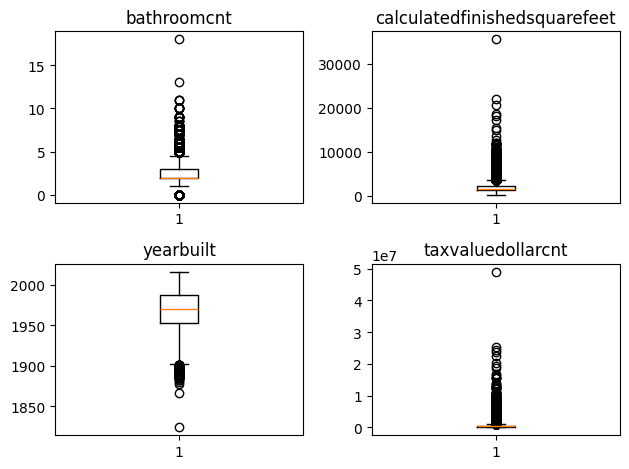

In [ ]:
# Boxplots to check outliers
for i, col in enumerate(selected_feature_target):
    plt.subplot(2, 2, i + 1)
    plt.boxplot(df[col].dropna())
    plt.title(col)
plt.tight_layout()
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


**2.B Answer:**
*   **Distribution and outliers:** None of our selected variables follow a normal distribution, and all exhibit notable outliers. Both **bathroomcnt** and **calculatedfinishedsquarefeet** are right-skewed—most properties have less than 5 bathrooms and under 5,000 square feet, with a few extreme values (e.g., more than 5 bathrooms or 5,000 square feet) standing out as outliers (See boxplots above). **yearbuilt** shows a slight left skew, with most construction concentrated between 1950 and 2000, and a small number of much older properties dating back to the 1800s. The target variable, **taxvaluedollarcnt**, is heavily right-skewed, with a long tail representing a few high-value properties that are clear outliers.
*   **Reason for choosing the features:** We chose these three features because: (1) they directly relate to fundamental property characteristics that influence tax valuation; (2) they contain relatively few missing values, making them reliable; and (3) they have enough unique values to capture variability without being overly complex.



## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task!

In [ ]:
# Drop features that are unsuitable for the project
unsuitable_list = ['parcelid', 'fips', 'rawcensustractandblock', 'censustractandblock',
                   'latitude', 'longitude', 'propertyzoningdesc', 'propertycountylandusecode',
                   'assessmentyear'
                   ]
df_unsuitable_dropped = df.drop(columns = unsuitable_list)

df_unsuitable_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77414 entries, 0 to 77612
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         24953 non-null  float64
 1   architecturalstyletypeid      206 non-null    float64
 2   basementsqft                  50 non-null     float64
 3   bathroomcnt                   77381 non-null  float64
 4   bedroomcnt                    77381 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   buildingqualitytypeid         49672 non-null  float64
 7   calculatedbathnbr             76772 non-null  float64
 8   decktypeid                    614 non-null    float64
 9   finishedfloor1squarefeet      6023 non-null   float64
 10  calculatedfinishedsquarefeet  77185 non-null  float64
 11  finishedsquarefeet12          73749 non-null  float64
 12  finishedsquarefeet13          41 non-null     float64
 13  finish

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop.


**3.A Answer:** We made this decision based on our discussions in Part 2 (specifically Section 2.A.2). The features identified for removal fall into three main categories:
*   **Administrative or census-related identifiers** that are not directly relevant for business purposes — e.g., parcelid, fips, rawcensustractandblock, and censustractandblock. These serve more as unique identifiers than predictive features.
*   **Features that are complex to analyze or interpret, but could theoretically be used to engineer more meaningful variables** — e.g, latitude, longitude, propertyzoningdesc, and propertycountylandusecode. In these cases, we already have other features in the dataset (e.g., neighborhood, city, county, land use type) that capture similar information in a more usable form.
*   **Features that has to less or too many unique values** that add no information or generalizable information in the model - e.g., assessmentyear, parcelid, latitude, longitude

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully.

In [ ]:
# Check missing data in the new dataset
show_null_counts_features(df_unsuitable_dropped)

The dataset contains 77414 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
buildingclasstypeid            77399       99.98%   Numeric
finishedsquarefeet13           77373       99.95%   Numeric
basementsqft                   77364       99.94%   Numeric
storytypeid                    77364       99.94%   Numeric
yardbuildingsqft26             77344       99.91%   Numeric
fireplaceflag                  77242       99.78%   Categorical
architecturalstyletypeid       77208       99.73%   Numeric
typeconstructiontypeid         77192       99.71%   Numeric
finishedsquarefeet6            77028       99.50%   Numeric
pooltypeid10                   76950       99.40%   Numeric
decktypeid                     76800       99.21%   Numeric
poolsizesum                    76547       98.88%   Numeric
pooltypeid2                    76340       98.61%   Numeric
hashottuborspa                 75876       98.01%   Categoric

In [ ]:
exceptions = ['taxdelinquencyflag', 'poolcnt', 'fireplacecnt', 'unitcnt', 'garagecarcnt', 'hashottuborspa', 'basementsqft']

max_nulls = 50000  # Drop columns with more than 50,000 missing
df_null_dropped = df_unsuitable_dropped.loc[:,
                  (df_unsuitable_dropped.isnull().sum() < max_nulls) |
                  (df_unsuitable_dropped.columns.isin(exceptions))
                  ]

show_null_counts_features(df_null_dropped)

The dataset contains 77414 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
basementsqft                   77364       99.94%   Numeric
hashottuborspa                 75876       98.01%   Categorical
taxdelinquencyflag             74528       96.27%   Categorical
fireplacecnt                   69138       89.31%   Numeric
poolcnt                        61277       79.15%   Numeric
garagecarcnt                   51940       67.09%   Numeric
regionidneighborhood           46524       60.10%   Numeric
heatingorsystemtypeid          27974       36.14%   Numeric
buildingqualitytypeid          27742       35.84%   Numeric
unitcnt                        26851       34.68%   Numeric
lotsizesquarefeet              8272        10.69%   Numeric
finishedsquarefeet12           3665        4.73%   Numeric
regionidcity                   1504        1.94%   Numeric
fullbathcnt                    642         0.83%   Numeric


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



**3.B Answer:** As discussed in Section 2.A.3, we decided to remove features with more than 50,000 missing values, as they are difficult to impute reliably and could introduce inaccuracies or bias into the analysis. Before dropping any features, we considered that some missing values might actually indicate a value of 0—for example, taxdelinquencyflag (as noted in the appendix), poolcnt, fireplacecnt, unitcnt, hashottuborspa, basementsqft (no 0 values, which is unusal). We are also interested in the garage-related features. Since these features carry potentially meaningful information and may be related to property value, we decided to retain them for now. However, we acknowledge that this assumption may introduce some risk, and further validation or imputation strategies may be needed in future steps.

### Part 3.C: Drop Problematic **samples**

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


34 samples were dropped due to missing target.


Text(0.5, 0, 'taxvaluedollarcnt')

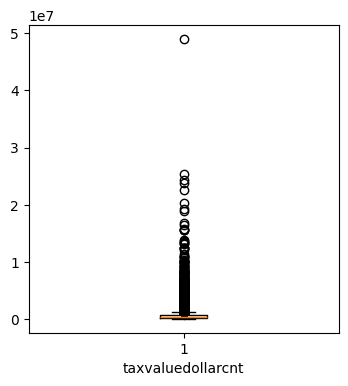

In [ ]:
# Drop samples where the target is missing
df_clean_missing_target = df_null_dropped[~df_null_dropped['taxvaluedollarcnt'].isna()]
print(f'{df_null_dropped.shape[0] - df_clean_missing_target.shape[0]} samples were dropped due to missing target.')

# Boxplot to check outlier
plt.figure(figsize=(4, 4))
plt.boxplot(df_clean_missing_target['taxvaluedollarcnt']);
plt.xlabel('taxvaluedollarcnt')

1013 samples were dropped due to outliers in target.


Text(0.5, 0, 'taxvaluedollarcnt')

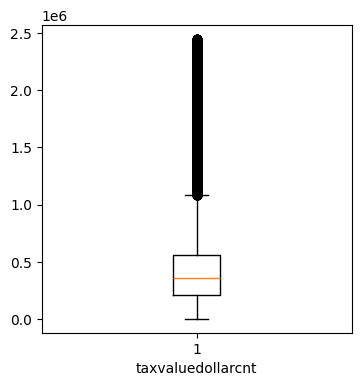

In [ ]:
# Drop samples with extreme outliers in the target (i.e., > 3SD from the mean)
from scipy.stats import zscore

z_scores = np.abs(zscore(df_clean_missing_target['taxvaluedollarcnt'])) # Calculate z-scores
df_clean_target = df_clean_missing_target[z_scores < 3]

print(f'{df_clean_missing_target.shape[0] - df_clean_target.shape[0]} samples were dropped due to outliers in target.')

# Boxplot to check outlier
plt.figure(figsize=(4, 4))
plt.boxplot(df_clean_target['taxvaluedollarcnt']);
plt.xlabel('taxvaluedollarcnt')

In [ ]:
# Drop samples with too many missing values (i.e., more than 50% nulls)
num_missing = int(df_clean_target.shape[1] * 0.5)
df_clean_missing = df_clean_target[df_clean_target.isnull().sum(axis=1) < num_missing]
print(f'{df_clean_target.shape[0] - df_clean_missing.shape[0]} samples were dropped due to too many missing values.')

273 samples were dropped due to too many missing values.


In [ ]:
# Check for duplicate rows
num_duplicates = df_clean_missing.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 350


In [ ]:
df_clean_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76094 entries, 0 to 77612
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  50 non-null     float64
 1   bathroomcnt                   76094 non-null  float64
 2   bedroomcnt                    76094 non-null  float64
 3   buildingqualitytypeid         49056 non-null  float64
 4   calculatedbathnbr             75777 non-null  float64
 5   calculatedfinishedsquarefeet  76088 non-null  float64
 6   finishedsquarefeet12          72763 non-null  float64
 7   fireplacecnt                  8210 non-null   float64
 8   fullbathcnt                   75777 non-null  float64
 9   garagecarcnt                  25183 non-null  float64
 10  hashottuborspa                1430 non-null   object 
 11  heatingorsystemtypeid         48749 non-null  float64
 12  lotsizesquarefeet             67995 non-null  float64
 13  poolcn

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


**3.C Answer:** We removed samples from the dataset if they met any of the following conditions:

1. **Missing target values or extreme outliers in the target variable**, defined as values more than 3 standard deviations away from the mean. These extreme values could be errors or just so unusual that they might mislead the model. We may run a sensitivity analysis to check how much these extreme outliers affect our model.

2. **Too many missing values across features**, as samples with a high proportion of missing data are difficult to impute reliably and can introduce noise or bias into the analysis.

3. **Duplicated records.** We notice that there are **199 duplicated rows in the original dataset**. As parcelid is unique for each property, we remove the 199 duplicated rows at the beggining because they do not add new information and may skew model training by giving disproportionate weight to repeated entries.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [ ]:
# Check missing values (7 features don't have missing values) and unique values
show_null_counts_features(df_clean_missing)
df_clean_missing.nunique().sort_values(ascending = True)

The dataset contains 76094 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
basementsqft                   76044       99.93%   Numeric
hashottuborspa                 74664       98.12%   Categorical
taxdelinquencyflag             73256       96.27%   Categorical
fireplacecnt                   67884       89.21%   Numeric
poolcnt                        60532       79.55%   Numeric
garagecarcnt                   50911       66.91%   Numeric
regionidneighborhood           45732       60.10%   Numeric
heatingorsystemtypeid          27345       35.94%   Numeric
buildingqualitytypeid          27038       35.53%   Numeric
unitcnt                        26296       34.56%   Numeric
lotsizesquarefeet              8099        10.64%   Numeric
finishedsquarefeet12           3331        4.38%   Numeric
regionidcity                   1420        1.87%   Numeric
calculatedbathnbr              317         0.42%   Numeric


poolcnt                             1
hashottuborspa                      1
taxdelinquencyflag                  1
regionidcounty                      3
fireplacecnt                        5
unitcnt                             7
fullbathcnt                        10
heatingorsystemtypeid              10
garagecarcnt                       12
buildingqualitytypeid              12
propertylandusetypeid              13
bedroomcnt                         15
roomcnt                            15
calculatedbathnbr                  17
bathroomcnt                        18
basementsqft                       43
yearbuilt                         136
regionidcity                      175
regionidzip                       388
regionidneighborhood              478
finishedsquarefeet12             4472
calculatedfinishedsquarefeet     4588
lotsizesquarefeet               18375
taxvaluedollarcnt               49838
dtype: int64

In [ ]:
df_imputed = df_clean_missing.copy()

In [ ]:
# Drop samples with missing value in features with < 5% NA
drop_NA_list = ['finishedsquarefeet12', 'regionidcity', 'calculatedbathnbr', 'fullbathcnt', 'yearbuilt', 'regionidzip', 'calculatedfinishedsquarefeet']
for feature in drop_NA_list:
  df_imputed = df_imputed.dropna(subset=[feature])
show_null_counts_features(df_imputed)

The dataset contains 71217 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
basementsqft                   71167       99.93%   Numeric
hashottuborspa                 69853       98.08%   Categorical
taxdelinquencyflag             68671       96.43%   Categorical
fireplacecnt                   63116       88.62%   Numeric
poolcnt                        56074       78.74%   Numeric
garagecarcnt                   46659       65.52%   Numeric
regionidneighborhood           42816       60.12%   Numeric
buildingqualitytypeid          25957       36.45%   Numeric
unitcnt                        25683       36.06%   Numeric
heatingorsystemtypeid          24453       34.34%   Numeric
lotsizesquarefeet              7945        11.16%   Numeric


In [ ]:
# To make life easier, we imputed garagecarcnt with "0", however as there is already 230 '0' counts, we create a new variable 'garageunknown'
df_imputed.insert(
    df_imputed.columns.get_loc('garagecarcnt') + 1,
    'garageunknown',
    np.where(df_imputed['garagecarcnt'].isna(), 1, 0)
)

In [ ]:
# Impute features that missing indicate 0
missing_to_zero_list = ['taxdelinquencyflag', 'poolcnt', 'fireplacecnt', 'unitcnt', 'hashottuborspa', 'basementsqft', 'garagecarcnt']
for feature in missing_to_zero_list:
  df_imputed[feature] = df_imputed[feature].fillna(0)

show_null_counts_features(df_imputed)

The dataset contains 71217 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
regionidneighborhood           42816       60.12%   Numeric
buildingqualitytypeid          25957       36.45%   Numeric
heatingorsystemtypeid          24453       34.34%   Numeric
lotsizesquarefeet              7945        11.16%   Numeric


In [ ]:
# Impute numeric (continuous) features
# Impute lotsizesquarefeet with midian as it is skewed
missing_to_median_list = ['lotsizesquarefeet']
for feature in missing_to_median_list:
  df_imputed[feature] = df_imputed[feature].fillna(df_imputed[feature].median())

show_null_counts_features(df_imputed)

The dataset contains 71217 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
regionidneighborhood           42816       60.12%   Numeric
buildingqualitytypeid          25957       36.45%   Numeric
heatingorsystemtypeid          24453       34.34%   Numeric


In [ ]:
# Impute categorical features with mode
missing_to_mode_list = ['regionidneighborhood', 'buildingqualitytypeid', 'heatingorsystemtypeid']
for feature in missing_to_mode_list:
  df_imputed[feature] = df_imputed[feature].fillna(df_imputed[feature].mode().iloc[0])

show_null_counts_features(df_imputed)

The dataset contains 71217 samples.

There are no null values in the dataset!


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


**3.D Answer**: We applied four types of simple imputation strategies, tailored to different types of features and the nature of their missing values:

1.	**Dropping samples with <5% missing values in a feature**: The proportion of affected rows is small, and dropping them has a minimal impact on the overall dataset. Imputation in such cases adds unnecessary complexity for very little gain.

2. **Imputing features where missing values likely indicate ‘0’**:
Some features either explicitly state in the documentation (e.g., taxdelinquencyflag) or strongly suggest through their data pattern (e.g., only containing 1s and nulls) that missing values imply the absence of a condition or characteristic. For these, we imputed 0 to represent a lack of that feature.

3. **Imputing skewed continuous features with the median**: For numerical features with non-normal (skewed) distributions, we used the median to impute missing values. The median is more robust to outliers and better represents the central tendency in skewed data.

4. **Imputing categorical features with the mode**: For standard categorical features, we used the mode (most frequent category) to fill in missing values. This is a common and reasonable approach when the most common category is assumed to be a safe fallback for unknowns.

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary.

In [ ]:
df_main = df_imputed.copy()
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71217 entries, 0 to 77612
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  71217 non-null  float64
 1   bathroomcnt                   71217 non-null  float64
 2   bedroomcnt                    71217 non-null  float64
 3   buildingqualitytypeid         71217 non-null  float64
 4   calculatedbathnbr             71217 non-null  float64
 5   calculatedfinishedsquarefeet  71217 non-null  float64
 6   finishedsquarefeet12          71217 non-null  float64
 7   fireplacecnt                  71217 non-null  float64
 8   fullbathcnt                   71217 non-null  float64
 9   garagecarcnt                  71217 non-null  float64
 10  garageunknown                 71217 non-null  int64  
 11  hashottuborspa                71217 non-null  object 
 12  heatingorsystemtypeid         71217 non-null  float64
 13  lotsiz

In [ ]:
# As hashottuborspa and taxdelinquencyflag are binary, directly converted to bool
object_type_list = ['hashottuborspa', 'taxdelinquencyflag']

for feature in object_type_list:
  df_main[feature] = df_main[feature].astype(bool)

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71217 entries, 0 to 77612
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  71217 non-null  float64
 1   bathroomcnt                   71217 non-null  float64
 2   bedroomcnt                    71217 non-null  float64
 3   buildingqualitytypeid         71217 non-null  float64
 4   calculatedbathnbr             71217 non-null  float64
 5   calculatedfinishedsquarefeet  71217 non-null  float64
 6   finishedsquarefeet12          71217 non-null  float64
 7   fireplacecnt                  71217 non-null  float64
 8   fullbathcnt                   71217 non-null  float64
 9   garagecarcnt                  71217 non-null  float64
 10  garageunknown                 71217 non-null  int64  
 11  hashottuborspa                71217 non-null  bool   
 12  heatingorsystemtypeid         71217 non-null  float64
 13  lotsiz

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project.

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments.

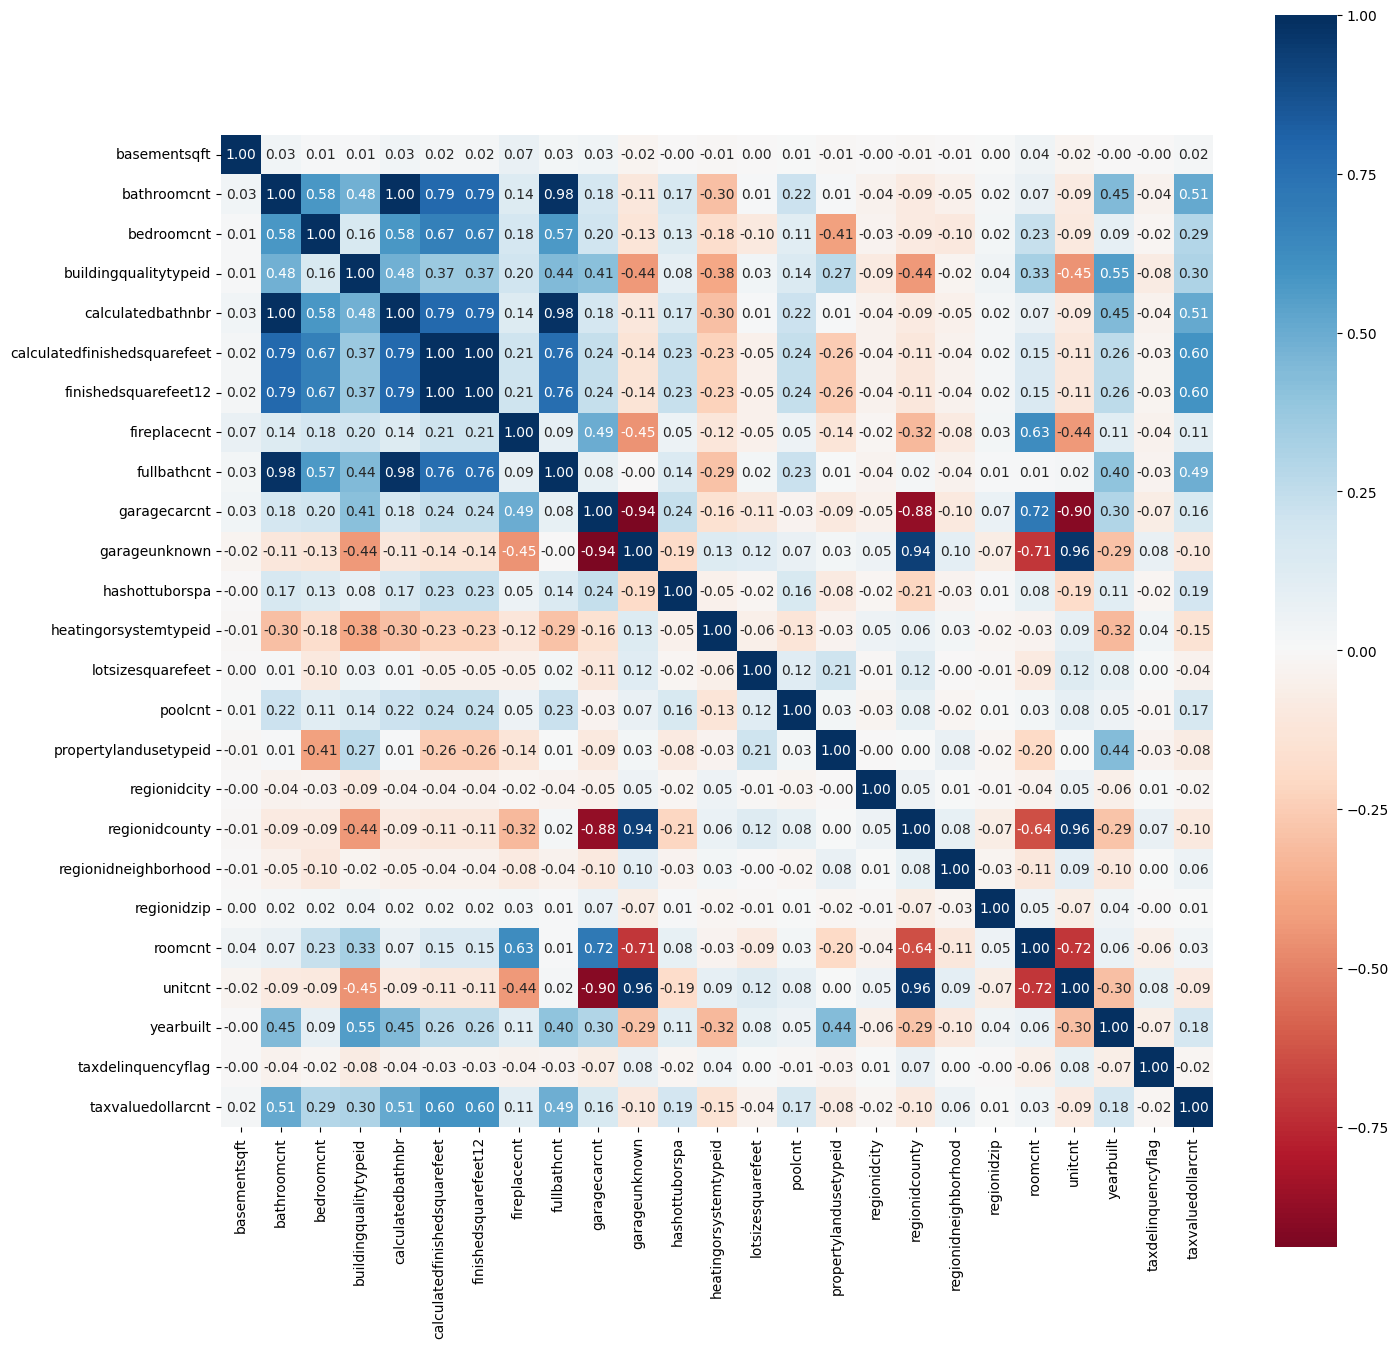

In [ ]:
# Heatmap to check correlation magnitude
plt.figure(figsize=(16, 16))
sns.heatmap(df_main.corr(), cmap='RdBu', annot=True, fmt='.2f', center=0, square=True);

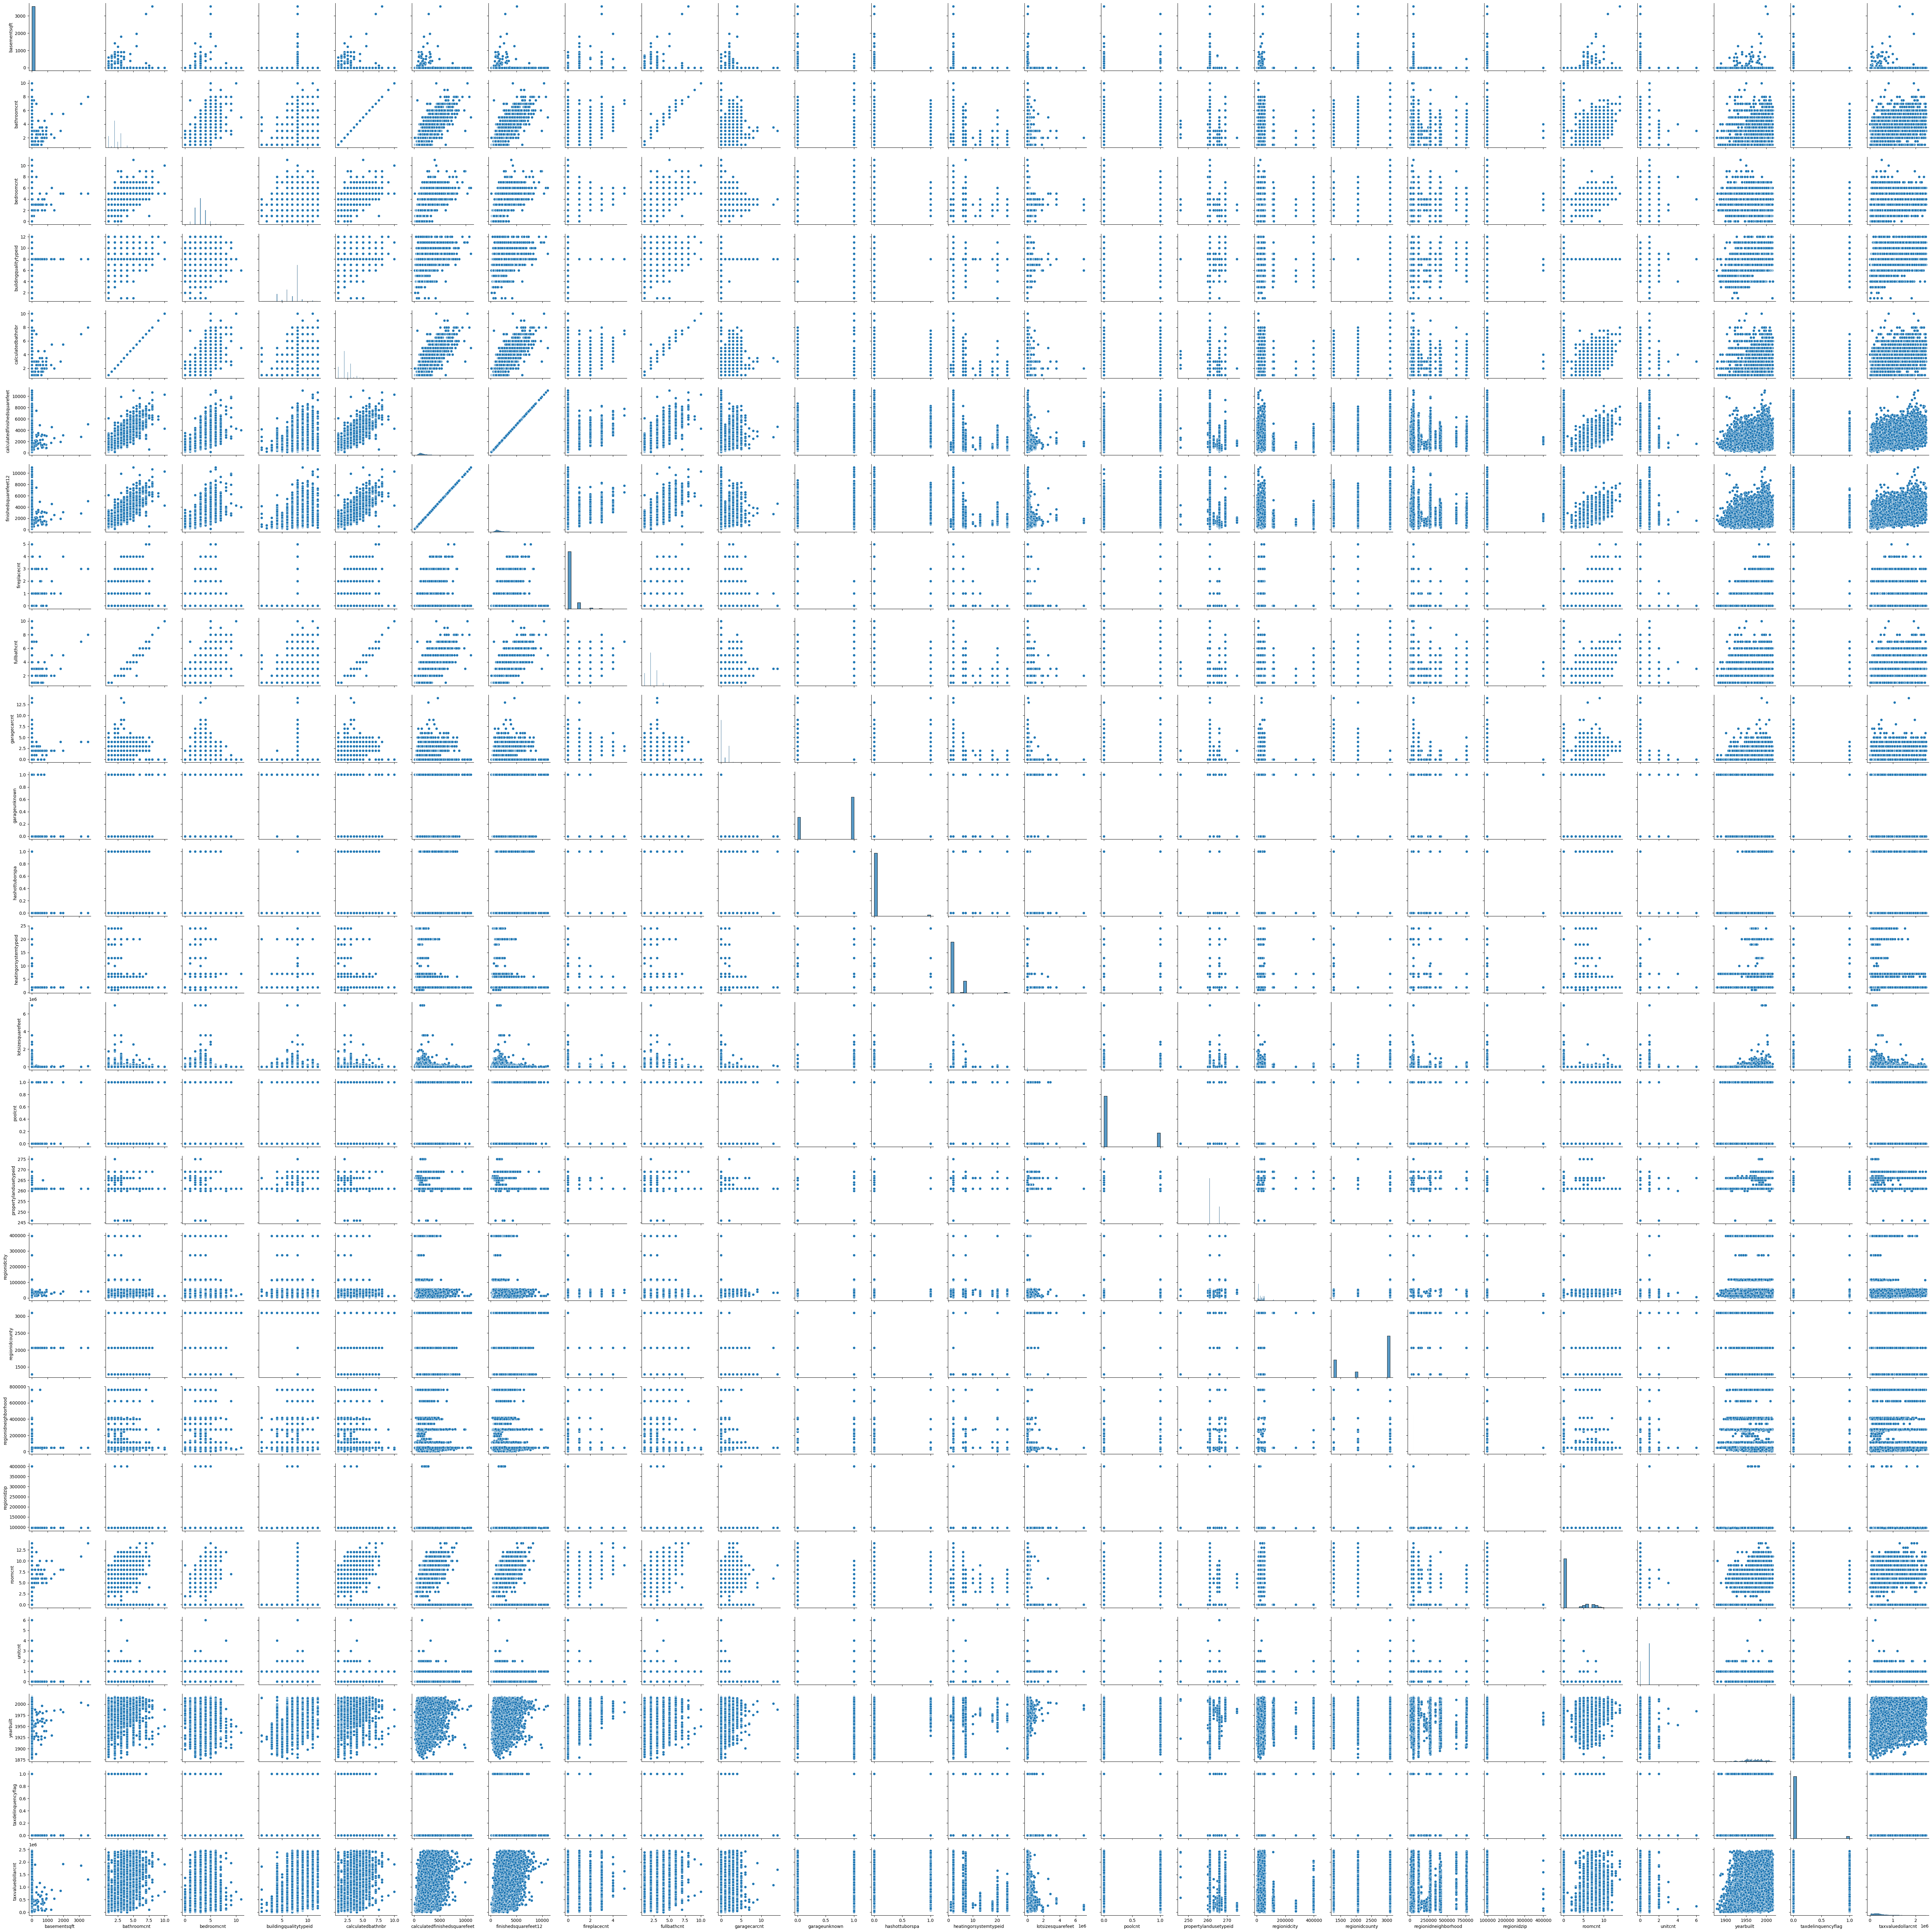

In [ ]:
# Pairplots to check patterns
sns.pairplot(df_main);

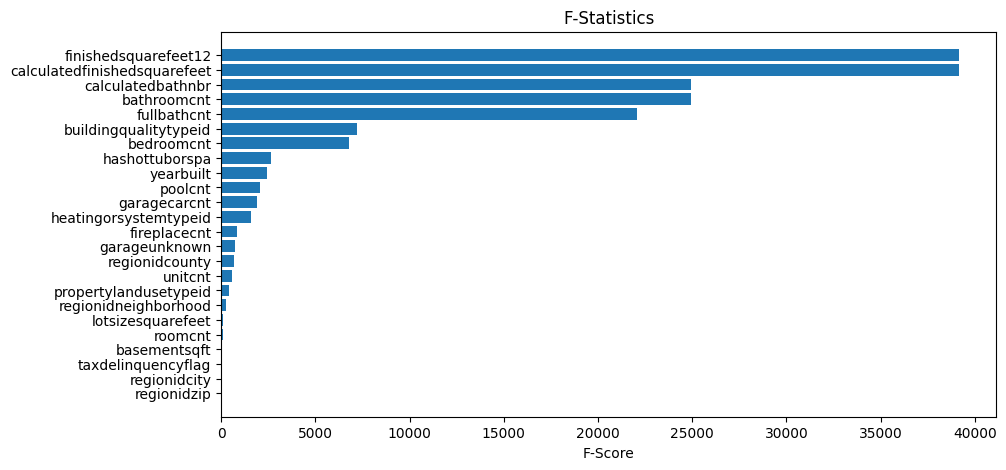

In [ ]:
# computing the f-statistic between the features
X = df_main.drop(columns=['taxvaluedollarcnt'])
y = df_main['taxvaluedollarcnt']

f_scores, p_values = f_regression(X,y)

df_f_results = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'p-value': p_values
}).sort_values(by='F-Score')

plt.figure(figsize=(10, 5))
plt.barh(df_f_results['Feature'], df_f_results['F-Score'])
plt.xlabel('F-Score')
plt.title('F-Statistics')
plt.show()

In [ ]:
# Forward Feature Selection

def forward_feature_selection(X, y, model,
                              scoring='neg_root_mean_squared_error',
                              cv=5,
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score

    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far

    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]

            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y,
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (RMSE): {current_score:.4f}")

        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()

        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )


In [ ]:
# Backward Feature Selection

def backward_feature_selection(X, y, model,
                               scoring='neg_root_mean_squared_error',
                               cv=5,
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=False
                              ):

    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y,
                                scoring=scoring, cv=cv,
                                n_jobs=n_jobs          ).mean()

    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)

    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)

    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)

    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')

    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features

    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')

        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None

        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set

        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break

        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()

        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)

        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )


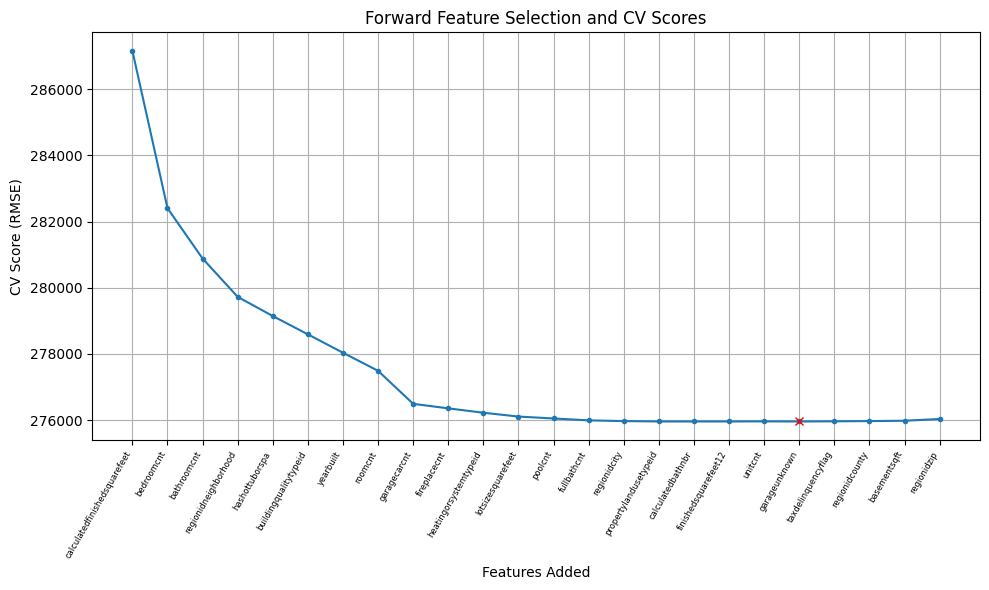

Best Features: ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', 'regionidneighborhood', 'hashottuborspa', 'buildingqualitytypeid', 'yearbuilt', 'roomcnt', 'garagecarcnt', 'fireplacecnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'fullbathcnt', 'regionidcity', 'propertylandusetypeid', 'calculatedbathnbr', 'finishedsquarefeet12', 'unitcnt', 'garageunknown']
Best CV Score: 275960.7277


In [ ]:
# Run forward feature selection
model = LinearRegression()

selected_features_forward, best_scores_forward, best_feature_set_forward, best_score_forward = forward_feature_selection(X, y, model, verbose=False)

# Plotting the results

index = np.argmax(np.array(selected_features_forward) == best_feature_set_forward[-1])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores_forward) + 1), best_scores_forward, marker='.')
plt.plot([index+1],best_score_forward,marker='x',color='red')
plt.xticks(range(1, len(selected_features_forward) + 1), selected_features_forward, rotation=60, ha='right', fontsize=6)
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and score
print(f"Best Features: {best_feature_set_forward}")
print(f"Best CV Score: {best_score_forward:.4f}")

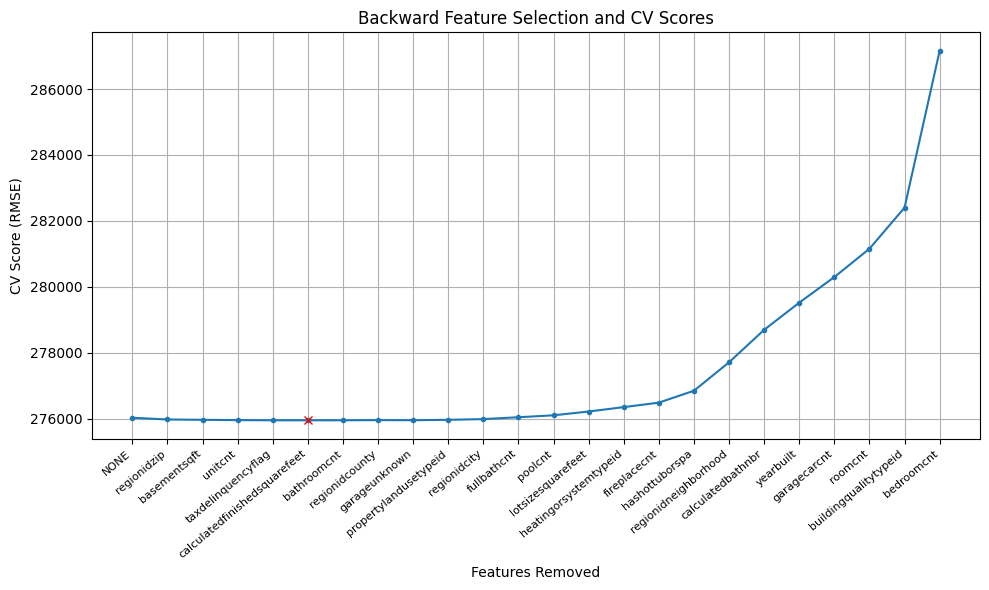

Best feature set: ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'finishedsquarefeet12', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garageunknown', 'hashottuborspa', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'roomcnt', 'yearbuilt']
CV score (RMSE): 275958.7288


In [ ]:
# Run backward feature selection
model = LinearRegression()

selected_features_backward, best_scores_backward, best_feature_set_backward, best_score_backward = backward_feature_selection(X, y, model=model, verbose=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.title('Backward Feature Selection and CV Scores')
plt.plot(range(1, len(best_scores_backward) + 1), best_scores_backward, marker='.')
index = np.argmin(best_scores_backward)
plt.plot([index + 1], best_scores_backward[index], marker='x', color='red')
plt.xticks(range(1, len(selected_features_backward) + 1), selected_features_backward, rotation=40, ha='right', fontsize=8)
plt.xlabel('Features Removed')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print minimum cv score

print("Best feature set:", best_feature_set_backward)
print("CV score (RMSE):",np.around(best_score_backward,4))

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships.
 How do the different methods for seeing relationships compare? Do they agree or disagree?



**4.A Answer**:
* **Relationships between target and features**: As shown in the heatmap, the target variable taxvaluedollarcnt has the strongest positive correlations with room count and property size-related features, including finishedsquarefeet12, calculatedfinishedsquarefeet, bathroomcnt, calculatedbathnbr, fullbathcnt, and bedroomcnt. These relationships are expected, as larger properties with more rooms generally have higher assessed values. Other property features such as buildingqualitytypeid, hashottuborspa, yearbuilt, poolcnt, garagecarcnt, and heatingorsystemtypeid show small to moderate correlations with the target. The F-statistics from univariate regression support these findings and align well with the heatmap results. These features were also consistently selected in both the forward and backward feature selection processes, reinforcing their relevance to predicting property value.


* **Relationships among features**: There are strong correlations among property size features (calculatedfinishedsquarefeet, finishedsquarefeet12) and room count-related features (bathroomcnt, calculatedbathnbr, fullbathcnt, bedroomcnt), indicating potential multicollinearity. This is further reflected in the feature selection results—adding additional room count or size-related features did not significantly improve model performance, despite their strong individual (bivariate) relationships with the target, e.g., calculatedfinishedsquarefeet was removed in the backward model. This suggests that the predictive information from these features is largely redundant. In addition, strong and notable correlations were observed among roomcnt, unitcnt, the garage-related variables, and regionidcounty, suggesting potential geographic patterns or structural property groupings based on location.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis.
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends.

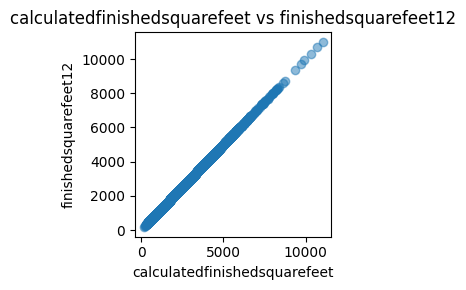

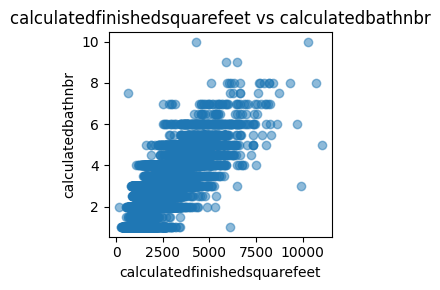

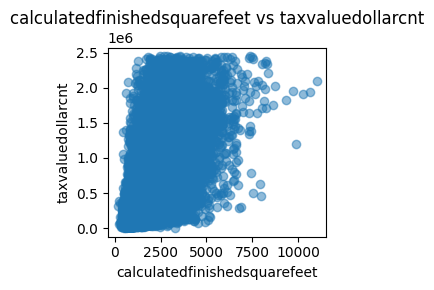

In [ ]:
feature_pairs = [
    ('calculatedfinishedsquarefeet', 'finishedsquarefeet12'),
    ('calculatedfinishedsquarefeet', 'calculatedbathnbr'),
    ('calculatedfinishedsquarefeet', 'taxvaluedollarcnt')
]

for col1, col2 in feature_pairs:
    plt.figure(figsize=(3, 3))
    plt.scatter(df_imputed[col1], df_imputed[col2], alpha=0.5)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f'{col1} vs {col2}')
    plt.tight_layout()
    plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


**4.B Answer**: The scatter plots reveal several clear patterns.
* The relationship between calculatedfinishedsquarefeet and finishedsquarefeet12 is nearly perfectly linear, indicating that these features capture the same information, and including both may be redundent.
* A positive relationship is also observed between calculatedfinishedsquarefeet and calculatedbathnbr, suggesting that larger homes tend to have more bathrooms, though with some variability.

* The plot of calculatedfinishedsquarefeet against taxvaluedollarcnt shows a general upward trend, implying that homes with greater living area are typically assessed at higher values. However, there is a noticeable difference in scale and distribution between the two variables—calculatedfinishedsquarefeet tends to have a larger raw scale.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset.
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection).
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary.

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question.

In [ ]:
df_transformed = df_main.copy()

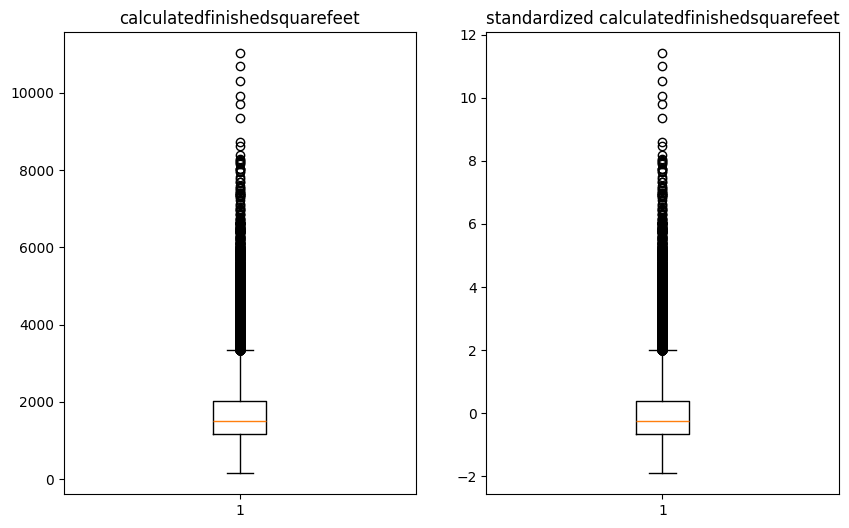

In [ ]:
# Standard Scaler for large variance numberic features
def standardized(df, column):
  scaler = StandardScaler()
  df[f'{column}_standardized'] = scaler.fit_transform(df[[column]])
  fig, axes = plt.subplots(1,2, figsize=(10,6));
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_standardized'])
  axes[1].set_title(f'standardized {column}')

standardized(df_transformed, 'calculatedfinishedsquarefeet')

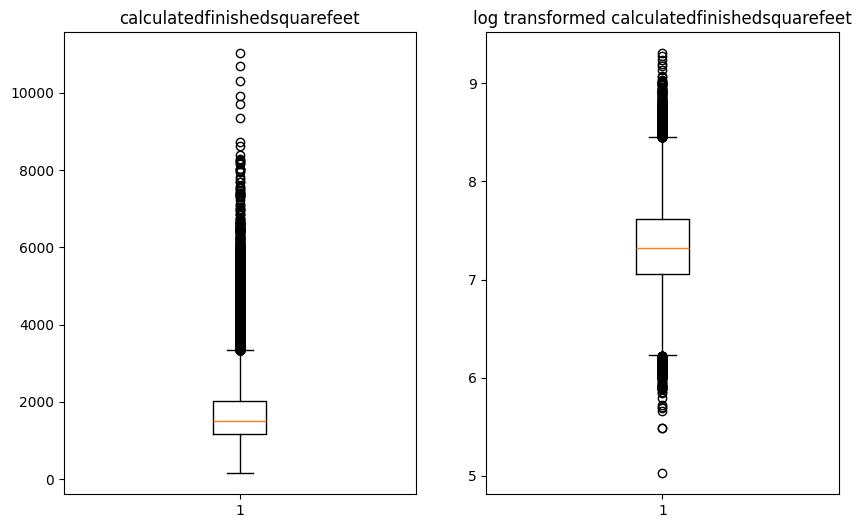

In [ ]:
# log transfer
def log_transformation(df, column):
  df[f'{column}_log_transformed'] = np.log(df[column])
  fig, axes = plt.subplots(1, 2, figsize=(10,6))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_log_transformed'])
  axes[1].set_title(f'log transformed {column}')

log_transformation(df_transformed, 'calculatedfinishedsquarefeet')

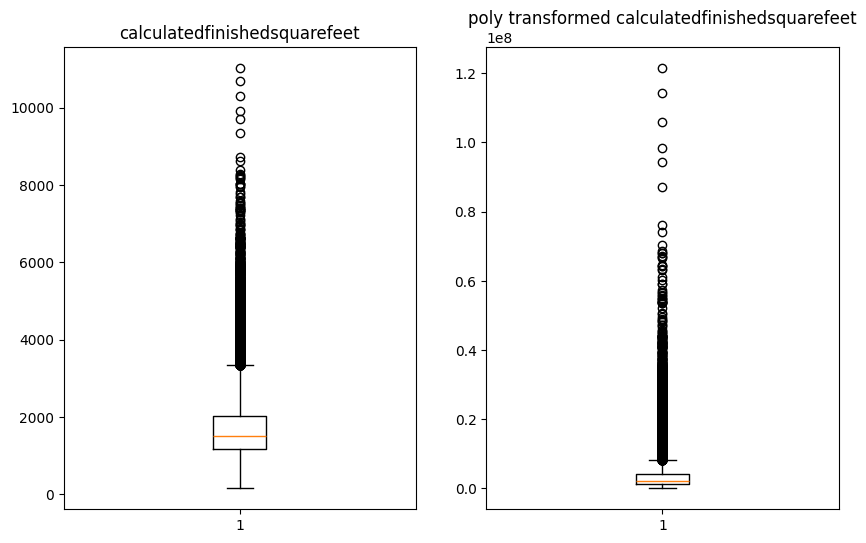

In [ ]:
# polynomial for calculatedbathnbr
def polynomial_transformation(df, column, degree):
  df[f'{column}_poly_transformed'] = df[column]**degree
  fig, axes = plt.subplots(1, 2, figsize=(10,6))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_poly_transformed'])
  axes[1].set_title(f'poly transformed {column}')

polynomial_transformation(df_transformed, 'calculatedfinishedsquarefeet', 2)

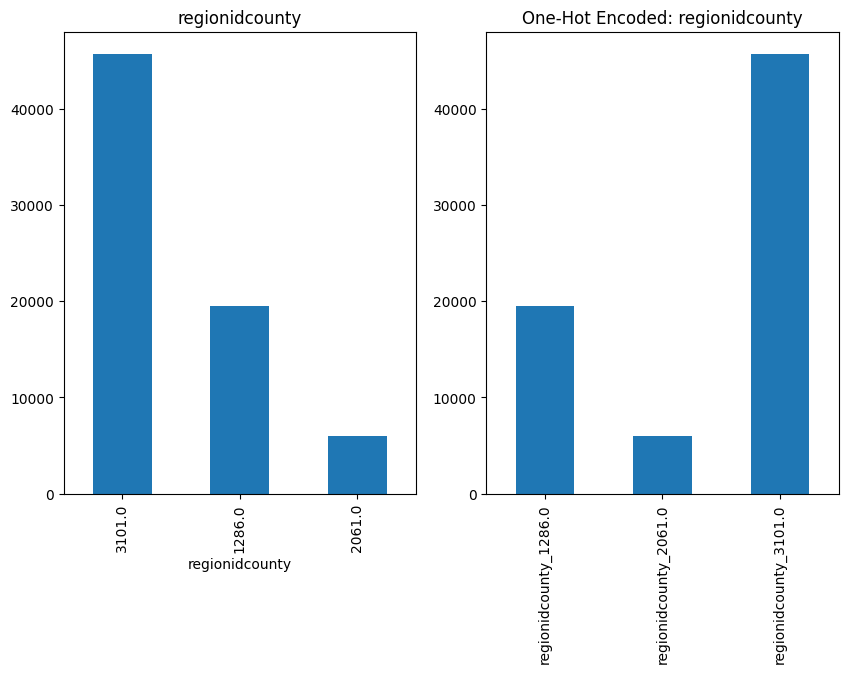

In [ ]:
# encoder for Categorical features
def OneHot(df, column):
  coder = OneHotEncoder()
  df[column] = df[column].astype(str)
  encoded_column = coder.fit_transform(df[[column]])
  df_encoded = pd.DataFrame(encoded_column.toarray(), columns=coder.get_feature_names_out([column]))

  fig, axes = plt.subplots(1,2, figsize=(10,6))
  df[column].value_counts().plot(kind='bar', ax=axes[0])
  axes[0].set_title(f'{column}')
  df_encoded.sum(axis=0).plot(kind='bar', ax=axes[1])
  axes[1].set_title(f'One-Hot Encoded: {column}')
  axes[1].tick_params(axis='x', rotation=90)

  df = pd.concat([df, df_encoded], axis=1)
  return df

df_encoded = OneHot(df_transformed, 'regionidcounty')

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed.


In [ ]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71217 entries, 0 to 77612
Data columns (total 28 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   basementsqft                                   71217 non-null  float64
 1   bathroomcnt                                    71217 non-null  float64
 2   bedroomcnt                                     71217 non-null  float64
 3   buildingqualitytypeid                          71217 non-null  float64
 4   calculatedbathnbr                              71217 non-null  float64
 5   calculatedfinishedsquarefeet                   71217 non-null  float64
 6   finishedsquarefeet12                           71217 non-null  float64
 7   fireplacecnt                                   71217 non-null  float64
 8   fullbathcnt                                    71217 non-null  float64
 9   garagecarcnt                                   71217 no

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77070 entries, 0 to 71201
Data columns (total 31 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   basementsqft                                   71217 non-null  float64
 1   bathroomcnt                                    71217 non-null  float64
 2   bedroomcnt                                     71217 non-null  float64
 3   buildingqualitytypeid                          71217 non-null  float64
 4   calculatedbathnbr                              71217 non-null  float64
 5   calculatedfinishedsquarefeet                   71217 non-null  float64
 6   finishedsquarefeet12                           71217 non-null  float64
 7   fireplacecnt                                   71217 non-null  float64
 8   fullbathcnt                                    71217 non-null  float64
 9   garagecarcnt                                   71217 no

**5 Answer**:
* We applied **standardization**, **logarithmic**, and **polynomial** transformations to the same feature, calculatedfinishedsquarefeet, to compare their effects. After standardization, the feature’s scale was reduced, but the original skewed distribution remained unchanged. The log transformation not only reduced the scale but also made the distribution more symmetrical and less skewed, which can be beneficial for linear models that assume normally distributed inputs. In contrast, the polynomial transformation (e.g., squaring the feature) dramatically increased the scale and increase the spread of outliers.

* We also applied **one-hot encoding** to regionidcounty, which generated new binary features representing each unique value in the original column.


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

